In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy import stats as st

cm = 1/2.54  # centimeters in inches
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

## Input data

In [110]:
L_s = 124.3 # m
B_s = 16.225 # m
T_s = 6.5 # m
S_s = 2530.6 # m^2
c_b = 0.599
# v_s_initial = 1 # kn
# v_s_final = 25 # kn
scale = 35
rho_m = 1000 # kg/m^3
rho_s = 1025 # kg/m^3
viscosity_m = 0.96822*10**(-6)
viscosity_s = 0.96822*10**(-6)

In [90]:
# v_s_kn = np.arange(v_s_initial, v_s_final)
v_s_kn = np.array([8.23, 9.82, 11.41, 13, 14.59, 16.35])
v_s_ms = v_s_kn*1852/3600
Fn_s = v_s_ms/(L_s*9.81)**0.5

L_m = L_s/scale
S_m = S_s/scale**2
v_m_ms = v_s_ms*(1/scale)**0.5
v_m_kn = v_m_ms*3600/1852
Fn_m = v_m_ms/(L_m*9.81)**0.5

## Resistance test data
$Re = \frac{vL}{\nu}$

$c_f = \frac{0.075}{(log_{10}Re_{model}-2)^2}$

In [92]:
resist_model = np.array([1.48131, 2.10915, 2.81547, 3.67875, 4.65975, 5.93505])
# resist_model = np.linspace(0.1,10,len(v_s_ms)) # N

c_t_model = resist_model/(0.5*rho_m*S_m*v_m_ms**2)
Re_model = v_m_ms*L_m/viscosity_m
c_f_model = 0.075/(np.log10(Re_model)-2)**2

Re_ship = v_s_ms*L_s/viscosity_s
c_f_ship = 0.075/(np.log10(Re_ship)-2)**2

## Resistance estimation: Froude's method
$c_{t_{ship}} = c_{t_{model}} - c_{f_{model}} + c_{f_{ship}} $

In [94]:
c_t_ship_Froude = c_t_model - c_f_model + c_f_ship 
R_ship_Froude = c_t_ship_Froude*(0.5*rho_s*S_s*v_s_ms**2)
R_ship_Froude

array([14250.43982395, 23372.09250495, 33490.32463777, 48129.36395712,
       65627.63056033, 90687.01589748])

## Form factor (1+k) estimation: Prohaska

Intercept: 0.7384351889311942
Slope: [0.11315742]
Coefficient of determination: 0.9438268397647458


<IPython.core.display.Javascript object>


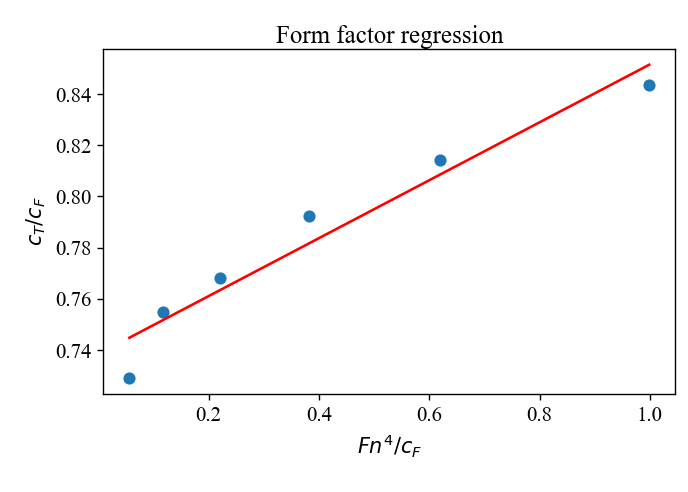

In [109]:
y_values = c_t_model/c_f_model
x_values = Fn_m**4/c_f_model

from sklearn.linear_model import LinearRegression
model_reg = LinearRegression()
model_reg.fit(x_values.reshape((-1, 1)), y_values)
r_sq = model_reg.score(x_values.reshape((-1, 1)), y_values)
form_factor = model_reg.intercept_
slope = model_reg.coef_

print(f"Intercept: {model_reg.intercept_}")
print(f"Slope: {model_reg.coef_}")
print(f"Coefficient of determination: {r_sq}")

# plt.figure()
# plt.scatter(x_values, y_values)
# plt.plot(x_values, x_values*slope+form_factor, color='red')


fig, ax = plt.subplots(1, figsize=(14*cm, 10*cm))
ax.set_title('Form factor regression', pad=1)
ax.set_xlabel('$Fn^4/c_F$')
ax.set_ylabel('$c_T/c_F$')
ax.scatter(x_values, y_values)
ax.plot(x_values, x_values*slope+form_factor, color='red')
plt.subplots_adjust(left=0.15, right=.98, top=0.90, bottom=0.20, hspace = 0.65, wspace=0.15)
plt.show()

## Form factor (1+k) estimation: Watanabe
$k_{wat} = -0.095 + 25.6*\frac{c_b}{(L/B)^2(B/T)^{0.5}}$

In [112]:
form_factor_Wat = 1 -0.095 + 25.6*c_b/((L_s/B_s)**2*(B_s/T_s)**0.5) 
print(form_factor_Wat)

1.0703705866083768


## Additive coefficient

In [106]:
# delta_cf = 0.000371627

# A_t = 25 ## Longitudal area exposed to wind 
# c_aa = 0.001*A_t/S_s

ks = 150e-6
delta_cf = 0.105*(ks/L_s)**(1/3)-0.00064
delta_cf

0.00047788211829117796

## Resistance estimation: Prohaska's method
$c_{t_{ship}} = c_{t_{model}} - (1+k)c_{f_{model}} + (1+k)c_{f_{ship}} + \Delta C_f$

<IPython.core.display.Javascript object>


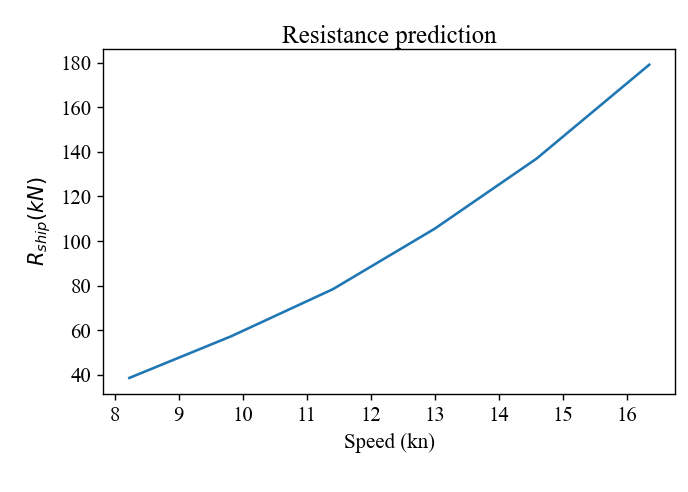

In [113]:
c_t_ship = c_t_model - form_factor*c_f_model + form_factor*c_f_ship + delta_cf
R_ship = c_t_ship*(0.5*rho_s*S_s*v_s_ms**2)
fig, ax = plt.subplots(1, figsize=(14*cm, 10*cm))
ax.set_title('Resistance prediction', pad=1)
ax.set_xlabel('Speed (kn)')
ax.set_ylabel('$R_{ship} (kN)$')
ax.plot(v_s_kn, R_ship/1e3)
plt.subplots_adjust(left=0.15, right=.98, top=0.90, bottom=0.20, hspace = 0.65, wspace=0.15)
plt.show()